In [1]:
import os
os.chdir(os.path.dirname('/home/huangyuqi/Documents/DeepLearningNotes/Note_6/RL_SH50/'))
print(os.getcwd())

/home/huangyuqi/Documents/DeepLearningNotes/Note_6/RL_SH50


In [3]:
import rqdatac
from rqdatac import *
rqdatac.init('xinjin', '123456', ('172.19.182.162', 16003))

In [4]:
import time

import pandas as pd
import numpy as np

In [5]:
from env.env_main import Account

In [6]:
stock_list = ['000300.XSHG', '000016.XSHG', '000905.XSHG']
start_date = '2012-01-01'
start_date_features = '2011-12-01'
end_date = '2017-06-30'
fields_daily = ['open', 'close']
fields_hf = ['open', 'high', 'low', 'close', 'total_turnover']

daily = get_price(stock_list, start_date, end_date, fields=fields_daily, adjust_type='post', frequency='1d')
high_freq = get_price(stock_list, start_date_features, end_date, fields=fields_hf, adjust_type='post', frequency='15m')

In [8]:
train_env = Account(daily_prices=daily, high_freq_data=high_freq)
print(len(train_env.features))
print(train_env.features[-1].shape)

1333
(64, 3, 31)


In [30]:
train_env.quote.table_close.shape

(1333, 3)

In [10]:
import multiprocessing
import threading
import tensorflow as tf
from agent.access import Access
from agent.framework import Framework

In [13]:
tf.reset_default_graph()
NUMS_CPU = multiprocessing.cpu_count()
state_size = train_env.features[-1].shape[-1]
batch_size = train_env.features[-1].shape[1]
action_size = 3
max_episodes = 200
model_path = 'model/saver_2.ckpt'
restore_model = False

In [17]:
GD = {}
class Worker(Framework):

    def __init__(self, name, access, batch_size, state_size, action_size):
        super().__init__(name, access, batch_size, state_size, action_size)
        self.env = train_env

    def run(self, sess, max_episodes, t_max=8):
        episode_score_list = []
        episode = 0
        while episode < max_episodes:
            episode += 1
            episode_score, _ = self.run_episode(sess, t_max)
            episode_score_list.append(episode_score)
            GD[str(self.name)] = episode_score_list
            if self.name == 'W0':
                print('Episode: %f, score: %f' % (episode, episode_score))
                print('\n')

In [20]:
tf.reset_default_graph()
t_start = time.ctime()
with tf.Session() as sess:
    
    with tf.device("/cpu:0"):
        
        A = Access(batch_size, state_size, action_size)
        if restore_model:
            A.restore(sess, model_path)
        F_list = []
        
        # writer = tf.summary.FileWriter("./model/output", sess.graph)
        # writer.flush()

        for i in range(NUMS_CPU):
            F_list.append(Worker('W%i' % i, A, batch_size, state_size, action_size))
            
        COORD = tf.train.Coordinator()
        sess.run(tf.global_variables_initializer())
        sess.graph.finalize()

        threads_list = []
        for ac in F_list:
            job = lambda: ac.run(sess, max_episodes)
            t = threading.Thread(target=job)
            t.start()
            threads_list.append(t)
            
        COORD.join(threads_list)
        
        A.save(sess, model_path)
        
        # writer.close()
        
t_end = time.ctime()

/home/huangyuqi/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


graph W0


graph W1


graph W2


graph W3


graph W4


graph W5


graph W6


graph W7


step_counter: 14, buffer length: 0, diff: 14
portfolio: [ 0.  0.  0.], position: [ 0 -1  1]
actor: -1.768742, actor_grad: 2.587679, policy mean: 0.333333, policy: -1.757793, entropy: -1.094923, critic: 1.455488, critic_grad: 3.432282, value: 1.455488, value_mean: 0.129157, advantage: -1.706159
Episode: 1.000000, score: 0.670788




Exception in thread Thread-27:
Traceback (most recent call last):
  File "/home/huangyuqi/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/huangyuqi/anaconda3/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-20-2d34623f0372>", line 24, in <lambda>
    job = lambda: ac.run(sess, max_episodes)
  File "<ipython-input-17-7fe65fa64792>", line 13, in run
    episode_score, _ = self.run_episode(sess, t_max)
  File "/home/huangyuqi/Documents/DeepLearningNotes/Note_6/RL_SH50/agent/framework.py", line 49, in run_episode
    next_state, reward, done = self.env.step(action)
  File "/home/huangyuqi/Documents/DeepLearningNotes/Note_6/RL_SH50/env/env_main.py", line 29, in step
    reward, done = self.quote.step(self.step_counter, actions)
TypeError: 'NoneType' object is not iterable



actor: 4.026349, actor_grad: 2.488570, policy mean: 0.333333, policy: 4.037137, entropy: -1.078770, critic: 6.532573, critic_grad: 10.169140, value: 6.532573, value_mean: 0.321281, advantage: 3.614574
Episode: 2.000000, score: 1.249579




actor: -5.584357, actor_grad: 2.521807, policy mean: 0.333333, policy: -5.573625, entropy: -1.073250, critic: 12.020956, critic_grad: 8.991982, value: 12.020956, value_mean: -0.060826, advantage: -4.774857
Episode: 3.000000, score: 1.052329




actor: -0.743668, actor_grad: 0.963135, policy mean: 0.333333, policy: -0.732872, entropy: -1.079612, critic: 1.552529, critic_grad: 1.270600, value: 1.552529, value_mean: -0.037424, advantage: -0.583619
Episode: 4.000000, score: 1.063912




actor: 1.783519, actor_grad: 1.519195, policy mean: 0.333333, policy: 1.793583, entropy: -1.006303, critic: 4.626228, critic_grad: 3.550984, value: 4.626228, value_mean: -0.099864, advantage: 1.662975
Episode: 5.000000, score: 0.910775




step_counter: 833, buffer length: 0, diff: 833
portfolio: [ 0.  0.  0.], position: [ 0.  0.  0.]


Exception in thread Thread-23:
Traceback (most recent call last):
  File "/home/huangyuqi/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/huangyuqi/anaconda3/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-20-2d34623f0372>", line 24, in <lambda>
    job = lambda: ac.run(sess, max_episodes)
  File "<ipython-input-17-7fe65fa64792>", line 13, in run
    episode_score, _ = self.run_episode(sess, t_max)
  File "/home/huangyuqi/Documents/DeepLearningNotes/Note_6/RL_SH50/agent/framework.py", line 49, in run_episode
    next_state, reward, done = self.env.step(action)
  File "/home/huangyuqi/Documents/DeepLearningNotes/Note_6/RL_SH50/env/env_main.py", line 29, in step
    reward, done = self.quote.step(self.step_counter, actions)
TypeError: 'NoneType' object is not iterable



actor: 0.080661, actor_grad: 0.911183, policy mean: 0.333333, policy: 0.090609, entropy: -0.994734, critic: 2.606284, critic_grad: 2.266921, value: 2.606284, value_mean: -0.283985, advantage: -0.146055
Episode: 6.000000, score: 0.652156




actor: 4.002987, actor_grad: 1.784126, policy mean: 0.333333, policy: 4.013656, entropy: -1.066871, critic: 16.139528, critic_grad: 6.740769, value: 16.139528, value_mean: 0.342567, advantage: 4.166041
Episode: 7.000000, score: 0.737740




actor: 2.195714, actor_grad: 0.884574, policy mean: 0.333333, policy: 2.205920, entropy: -1.020597, critic: 4.343647, critic_grad: 3.663665, value: 4.343647, value_mean: 0.019514, advantage: 2.226093
Episode: 8.000000, score: 1.106176




actor: 1.194815, actor_grad: 1.035314, policy mean: 0.333333, policy: 1.203425, entropy: -0.861094, critic: 4.005387, critic_grad: 2.322157, value: 4.005387, value_mean: -0.028885, advantage: 0.967552
Episode: 9.000000, score: 1.259207




actor: 4.814564, actor_grad: 4.094895, policy mean: 0.333372, policy: 4.821775, entropy: -0.720986, critic: 20.632729, critic_grad: 8.307117, value: 20.632729, value_mean: 0.113852, advantage: 6.320972
Episode: 10.000000, score: 1.906041




actor: 0.397346, actor_grad: 0.339300, policy mean: 0.333333, policy: 0.407004, entropy: -0.965886, critic: 0.089659, critic_grad: 0.540411, value: 0.089659, value_mean: 0.093983, advantage: 0.380973
Episode: 11.000000, score: 0.957859




actor: -1.006645, actor_grad: 1.347721, policy mean: 0.333333, policy: -0.996165, entropy: -1.048028, critic: 2.948197, critic_grad: 1.764629, value: 2.948197, value_mean: 0.352252, advantage: -1.148890
Episode: 12.000000, score: 0.607598




actor: 1.617660, actor_grad: 1.041714, policy mean: 0.333333, policy: 1.627487, entropy: -0.982640, critic: 3.868932, critic_grad: 2.593428, value: 3.868932, value_mean: 0.244422, advantage: 1.628632
Episode: 13.000000, score: 0.673360




step_counter: 57, buffer length: 0, diff: 57
portfolio: [ 0.  0.  0.], position: [ 0.  0.  0.]


Exception in thread Thread-24:
Traceback (most recent call last):
  File "/home/huangyuqi/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/huangyuqi/anaconda3/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-20-2d34623f0372>", line 24, in <lambda>
    job = lambda: ac.run(sess, max_episodes)
  File "<ipython-input-17-7fe65fa64792>", line 13, in run
    episode_score, _ = self.run_episode(sess, t_max)
  File "/home/huangyuqi/Documents/DeepLearningNotes/Note_6/RL_SH50/agent/framework.py", line 49, in run_episode
    next_state, reward, done = self.env.step(action)
  File "/home/huangyuqi/Documents/DeepLearningNotes/Note_6/RL_SH50/env/env_main.py", line 29, in step
    reward, done = self.quote.step(self.step_counter, actions)
TypeError: 'NoneType' object is not iterable



actor: -1.032500, actor_grad: 1.522964, policy mean: 0.333333, policy: -1.023197, entropy: -0.930244, critic: 1.503112, critic_grad: 1.048912, value: 1.503112, value_mean: 0.231405, advantage: -0.779888
Episode: 14.000000, score: 0.694878

step_counter: 47, buffer length: 0, diff: 47

portfolio: [ 0.  0.  0.], position: [ 0.  0.  0.]


Exception in thread Thread-21:
Traceback (most recent call last):
  File "/home/huangyuqi/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/huangyuqi/anaconda3/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-20-2d34623f0372>", line 24, in <lambda>
    job = lambda: ac.run(sess, max_episodes)
  File "<ipython-input-17-7fe65fa64792>", line 13, in run
    episode_score, _ = self.run_episode(sess, t_max)
  File "/home/huangyuqi/Documents/DeepLearningNotes/Note_6/RL_SH50/agent/framework.py", line 49, in run_episode
    next_state, reward, done = self.env.step(action)
  File "/home/huangyuqi/Documents/DeepLearningNotes/Note_6/RL_SH50/env/env_main.py", line 29, in step
    reward, done = self.quote.step(self.step_counter, actions)
TypeError: 'NoneType' object is not iterable



actor: -6.030404, actor_grad: 4.380825, policy mean: 0.333464, policy: -6.023769, entropy: -0.663480, critic: 9.223620, critic_grad: 5.448889, value: 9.223620, value_mean: 0.040155, advantage: -4.133111
Episode: 15.000000, score: 1.023297




actor: -2.052930, actor_grad: 1.044063, policy mean: 0.333612, policy: -2.044900, entropy: -0.803020, critic: 1.160103, critic_grad: 1.906687, value: 1.160103, value_mean: 0.112176, advantage: -1.421513
Episode: 16.000000, score: 2.314937




actor: 3.333107, actor_grad: 0.374505, policy mean: 0.333333, policy: 3.336627, entropy: -0.351974, critic: 3.486493, critic_grad: 1.528428, value: 3.486493, value_mean: -0.069243, advantage: 0.700057
Episode: 17.000000, score: 0.798641




step_counter: 39, buffer length: 0, diff: 39
portfolio: [ 0.  0.  0.], position: [ 0.  0.  0.]
step_counter: 39, buffer length: 0, diff: 39
portfolio: [ 0.  0.  0.], position: [0 0 0]


Exception in thread Thread-22:
Traceback (most recent call last):
  File "/home/huangyuqi/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/huangyuqi/anaconda3/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-20-2d34623f0372>", line 24, in <lambda>
    job = lambda: ac.run(sess, max_episodes)
  File "<ipython-input-17-7fe65fa64792>", line 13, in run
    episode_score, _ = self.run_episode(sess, t_max)
  File "/home/huangyuqi/Documents/DeepLearningNotes/Note_6/RL_SH50/agent/framework.py", line 49, in run_episode
    next_state, reward, done = self.env.step(action)
  File "/home/huangyuqi/Documents/DeepLearningNotes/Note_6/RL_SH50/env/env_main.py", line 29, in step
    reward, done = self.quote.step(self.step_counter, actions)
TypeError: 'NoneType' object is not iterable
Exception in thread Thread-25:
Traceback (most recent call last):
  File "/home/huangyuqi/anaconda3/lib/py

actor: 0.203813, actor_grad: 0.235655, policy mean: 0.333333, policy: 0.213633, entropy: -0.982012, critic: 0.863389, critic_grad: 0.683255, value: 0.863389, value_mean: -0.015774, advantage: 0.246285
Episode: 18.000000, score: 0.544291




actor: -3.837463, actor_grad: 0.883457, policy mean: 0.333333, policy: -3.830996, entropy: -0.646721, critic: 2.679656, critic_grad: 3.046528, value: 2.679656, value_mean: -0.095371, advantage: -2.032502
Episode: 19.000000, score: 0.900069




actor: 1.102608, actor_grad: 0.669611, policy mean: 0.333333, policy: 1.107684, entropy: -0.507553, critic: 1.636864, critic_grad: 1.566177, value: 1.636864, value_mean: -0.206037, advantage: 1.028976
Episode: 20.000000, score: 0.632166




actor: 13.237061, actor_grad: 0.000000, policy mean: 0.333333, policy: 13.238178, entropy: -0.111902, critic: 12.042866, critic_grad: 5.960383, value: 12.042866, value_mean: 0.107749, advantage: 4.299117
Episode: 21.000000, score: 0.844681




actor: -4.227728, actor_grad: 0.700000, policy mean: 0.333333, policy: -4.220964, entropy: -0.676392, critic: 3.838774, critic_grad: 3.582778, value: 3.838774, value_mean: -0.059553, advantage: -2.521168
Episode: 22.000000, score: 0.538536




actor: 0.189816, actor_grad: 0.639963, policy mean: 0.333333, policy: 0.199898, entropy: -1.008176, critic: 1.214125, critic_grad: 0.434243, value: 1.214125, value_mean: -0.038271, advantage: 0.052486
Episode: 23.000000, score: 0.741058




actor: -3.212492, actor_grad: 0.620999, policy mean: 0.333333, policy: -3.205070, entropy: -0.742160, critic: 7.594255, critic_grad: 3.214562, value: 7.594255, value_mean: -0.089721, advantage: -2.367697
Episode: 24.000000, score: 0.939966




actor: -2.050482, actor_grad: 0.621688, policy mean: 0.333333, policy: -2.044536, entropy: -0.594553, critic: 3.675591, critic_grad: 3.006974, value: 3.675591, value_mean: -0.238694, advantage: -1.953972
Episode: 25.000000, score: 0.930824




actor: -0.941971, actor_grad: 1.738783, policy mean: 0.333333, policy: -0.937513, entropy: -0.445739, critic: 2.165343, critic_grad: 1.383283, value: 2.165343, value_mean: -0.103924, advantage: -0.564762
Episode: 26.000000, score: 0.752253




actor: 0.076932, actor_grad: 0.642295, policy mean: 0.333333, policy: 0.085594, entropy: -0.866194, critic: 0.974371, critic_grad: 0.784501, value: 0.974371, value_mean: -0.125374, advantage: 0.121688
Episode: 27.000000, score: 1.011521




actor: -1.356408, actor_grad: 1.831706, policy mean: 0.333333, policy: -1.349360, entropy: -0.704841, critic: 2.417994, critic_grad: 1.695678, value: 2.417994, value_mean: 0.036946, advantage: -1.291438
Episode: 28.000000, score: 0.676426




actor: -4.208191, actor_grad: 0.964263, policy mean: 0.333333, policy: -4.204613, entropy: -0.357774, critic: 5.217067, critic_grad: 4.410331, value: 5.217067, value_mean: -0.078597, advantage: -2.976634
Episode: 29.000000, score: 0.859710




actor: 3.629067, actor_grad: 1.570620, policy mean: 0.333333, policy: 3.637726, entropy: -0.865851, critic: 8.869648, critic_grad: 5.266016, value: 8.869648, value_mean: -0.056041, advantage: 3.934474
Episode: 30.000000, score: 0.997062




actor: 4.493797, actor_grad: 4.087531, policy mean: 0.333333, policy: 4.497743, entropy: -0.394629, critic: 22.310024, critic_grad: 9.935608, value: 22.310024, value_mean: -0.298098, advantage: 5.355504
Episode: 31.000000, score: 1.144678




actor: -1.677592, actor_grad: 3.789146, policy mean: 0.333333, policy: -1.670331, entropy: -0.726037, critic: 2.810256, critic_grad: 2.914922, value: 2.810256, value_mean: -0.115747, advantage: -2.092084
Episode: 32.000000, score: 0.756827




actor: -1.270014, actor_grad: 2.105258, policy mean: 0.333396, policy: -1.262954, entropy: -0.706039, critic: 2.255512, critic_grad: 2.470569, value: 2.255512, value_mean: -0.139883, advantage: -1.605876
Episode: 33.000000, score: 0.734519




actor: -0.440245, actor_grad: 0.745974, policy mean: 0.333371, policy: -0.433592, entropy: -0.665309, critic: 0.969715, critic_grad: 0.572186, value: 0.969715, value_mean: -0.117319, advantage: 0.028425
Episode: 34.000000, score: 1.212169




actor: 3.037341, actor_grad: 0.793739, policy mean: 0.333344, policy: 3.040375, entropy: -0.303361, critic: 3.884584, critic_grad: 2.268221, value: 3.884584, value_mean: -0.093518, advantage: 1.449627
Episode: 35.000000, score: 0.990670




actor: 2.784657, actor_grad: 1.104046, policy mean: 0.333333, policy: 2.787401, entropy: -0.274420, critic: 2.292397, critic_grad: 1.790735, value: 2.292397, value_mean: -0.024556, advantage: 1.413903
Episode: 36.000000, score: 0.804647




actor: 9.278698, actor_grad: 0.000000, policy mean: 0.333333, policy: 9.279817, entropy: -0.111902, critic: 5.921989, critic_grad: 4.337463, value: 5.921989, value_mean: -0.156982, advantage: 2.943826
Episode: 37.000000, score: 1.001411




actor: -4.178556, actor_grad: 1.956455, policy mean: 0.333385, policy: -4.177433, entropy: -0.112443, critic: 2.570634, critic_grad: 4.034086, value: 2.570634, value_mean: -0.374526, advantage: -2.031591
Episode: 38.000000, score: 0.942733




actor: 0.300700, actor_grad: 0.000438, policy mean: 0.333428, policy: 0.301829, entropy: -0.112877, critic: 1.073282, critic_grad: 1.171568, value: 1.073282, value_mean: -0.476675, advantage: 0.556038
Episode: 39.000000, score: 1.151337




actor: 3.090353, actor_grad: 0.000000, policy mean: 0.333333, policy: 3.091472, entropy: -0.111902, critic: 1.927921, critic_grad: 1.843125, value: 1.927921, value_mean: -0.106522, advantage: 1.353885
Episode: 40.000000, score: 1.000161




actor: -1.340448, actor_grad: 0.000000, policy mean: 0.333333, policy: -1.339329, entropy: -0.111902, critic: 1.045375, critic_grad: 2.100464, value: 1.045375, value_mean: -0.391676, advantage: -1.000875
Episode: 41.000000, score: 0.901668




actor: 3.339627, actor_grad: 0.000000, policy mean: 0.333333, policy: 3.340746, entropy: -0.111902, critic: 1.283226, critic_grad: 1.276796, value: 1.283226, value_mean: 0.037868, advantage: 0.878065
Episode: 42.000000, score: 1.230965




actor: -10.864711, actor_grad: 0.000000, policy mean: 0.333333, policy: -10.863591, entropy: -0.111902, critic: 7.109699, critic_grad: 7.733715, value: 7.109699, value_mean: -0.291969, advantage: -3.426148
Episode: 43.000000, score: 0.735708




actor: -5.341742, actor_grad: 0.000229, policy mean: 0.333365, policy: -5.340620, entropy: -0.112231, critic: 17.325153, critic_grad: 8.987059, value: 17.325153, value_mean: -0.462371, advantage: -4.715171
Episode: 44.000000, score: 0.858115




actor: 1.781610, actor_grad: 0.000000, policy mean: 0.333333, policy: 1.782729, entropy: -0.111902, critic: 2.304377, critic_grad: 1.742046, value: 2.304377, value_mean: -0.435637, advantage: 0.072770
Episode: 45.000000, score: 0.721558




actor: -4.837078, actor_grad: 0.064033, policy mean: 0.333580, policy: -4.835927, entropy: -0.115109, critic: 9.310780, critic_grad: 10.729590, value: 9.310780, value_mean: -0.588399, advantage: -3.924484
Episode: 46.000000, score: 0.869182




actor: -4.795768, actor_grad: 0.051595, policy mean: 0.333751, policy: -4.794578, entropy: -0.119128, critic: 7.217296, critic_grad: 3.938555, value: 7.217296, value_mean: -0.057027, advantage: -3.082888
Episode: 47.000000, score: 0.952983




actor: -0.979553, actor_grad: 0.034950, policy mean: 0.334244, policy: -0.978309, entropy: -0.124404, critic: 1.091693, critic_grad: 1.172427, value: 1.091693, value_mean: -0.091016, advantage: 0.151137
Episode: 48.000000, score: 0.996964




actor: -2.464664, actor_grad: 0.000000, policy mean: 0.333333, policy: -2.463544, entropy: -0.111902, critic: 1.251731, critic_grad: 1.422706, value: 1.251731, value_mean: -0.128056, advantage: -1.009618
Episode: 49.000000, score: 0.994389




actor: 7.868415, actor_grad: 0.000000, policy mean: 0.333333, policy: 7.869534, entropy: -0.111902, critic: 8.826448, critic_grad: 4.539848, value: 8.826448, value_mean: -0.023768, advantage: 3.525064
Episode: 50.000000, score: 1.179832




actor: 11.333832, actor_grad: 0.000000, policy mean: 0.333333, policy: 11.334950, entropy: -0.111902, critic: 16.947649, critic_grad: 6.576122, value: 16.947649, value_mean: 0.065383, advantage: 5.305845
Episode: 51.000000, score: 1.230763




actor: -1.352484, actor_grad: 0.000000, policy mean: 0.333333, policy: -1.351365, entropy: -0.111902, critic: 1.045896, critic_grad: 1.045861, value: 1.045896, value_mean: 0.070218, advantage: -0.725528
Episode: 52.000000, score: 1.254301




actor: -1.819562, actor_grad: 0.000000, policy mean: 0.333333, policy: -1.818443, entropy: -0.111902, critic: 1.848065, critic_grad: 1.115293, value: 1.848065, value_mean: -0.028456, advantage: -0.560231
Episode: 53.000000, score: 1.260815




actor: -0.547948, actor_grad: 0.000000, policy mean: 0.333333, policy: -0.546829, entropy: -0.111902, critic: 0.818050, critic_grad: 0.437300, value: 0.818050, value_mean: 0.190462, advantage: -0.249118
Episode: 54.000000, score: 0.961392




actor: 0.820054, actor_grad: 0.000000, policy mean: 0.333333, policy: 0.821173, entropy: -0.111902, critic: 4.521341, critic_grad: 2.650565, value: 4.521341, value_mean: -0.007301, advantage: 0.564868
Episode: 55.000000, score: 1.025091




actor: -1.096125, actor_grad: 0.000000, policy mean: 0.333333, policy: -1.095006, entropy: -0.111902, critic: 5.930502, critic_grad: 2.124618, value: 5.930502, value_mean: 0.122406, advantage: 0.910844
Episode: 56.000000, score: 1.510920




actor: -8.652080, actor_grad: 0.000000, policy mean: 0.333333, policy: -8.650961, entropy: -0.111902, critic: 7.113794, critic_grad: 3.294368, value: 7.113794, value_mean: 0.068372, advantage: -2.776945
Episode: 57.000000, score: 0.828439




actor: 1.904908, actor_grad: 0.000000, policy mean: 0.333333, policy: 1.906027, entropy: -0.111902, critic: 4.462974, critic_grad: 1.292503, value: 4.462974, value_mean: 0.061088, advantage: 0.762255
Episode: 58.000000, score: 0.692158




step_counter: 316, buffer length: 0, diff: 316
portfolio: [ 0.  0.  0.], position: [ 0.  0.  0.]


Exception in thread Thread-20:
Traceback (most recent call last):
  File "/home/huangyuqi/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/huangyuqi/anaconda3/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-20-2d34623f0372>", line 24, in <lambda>
    job = lambda: ac.run(sess, max_episodes)
  File "<ipython-input-17-7fe65fa64792>", line 13, in run
    episode_score, _ = self.run_episode(sess, t_max)
  File "/home/huangyuqi/Documents/DeepLearningNotes/Note_6/RL_SH50/agent/framework.py", line 49, in run_episode
    next_state, reward, done = self.env.step(action)
  File "/home/huangyuqi/Documents/DeepLearningNotes/Note_6/RL_SH50/env/env_main.py", line 29, in step
    reward, done = self.quote.step(self.step_counter, actions)
TypeError: 'NoneType' object is not iterable



In [22]:
print(t_start)
print(t_end)

Sat Dec 16 21:59:17 2017
Sat Dec 16 22:12:19 2017


In [23]:
from agent.actor_critic import Agent
from env.env_main import Account

import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

In [24]:
tf.reset_default_graph()
test_env = train_env

In [25]:
state_size = test_env.features[-1].shape[-1]
batch_size = test_env.features[-1].shape[1]
action_size = 3

In [26]:
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
with tf.Session() as sess:
    
    with tf.device("/cpu:0"):
        
        A = Access(batch_size, state_size, action_size)
        W = Agent('W0', A, batch_size, state_size, action_size)
        A.restore(sess, model_path)
        W.init_or_update_local(sess)
        
        env = test_env
        state = env.reset()
        for _ in range(1000):
            action = W.get_deterministic_policy_action(sess, state)
            state, reward, done = env.step(action)

value, reward = env.plot_data()


/home/huangyuqi/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


graph W0
INFO:tensorflow:Restoring parameters from model/saver_2.ckpt


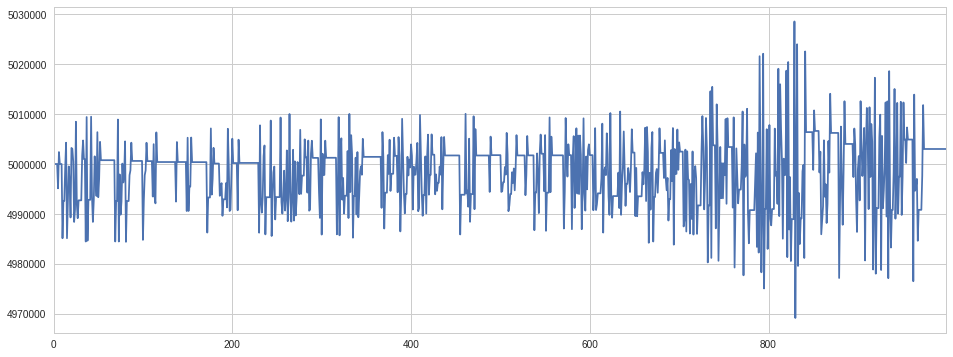

In [27]:
value, reward = env.plot_data()

pd.Series(value).plot(figsize=(16, 6))

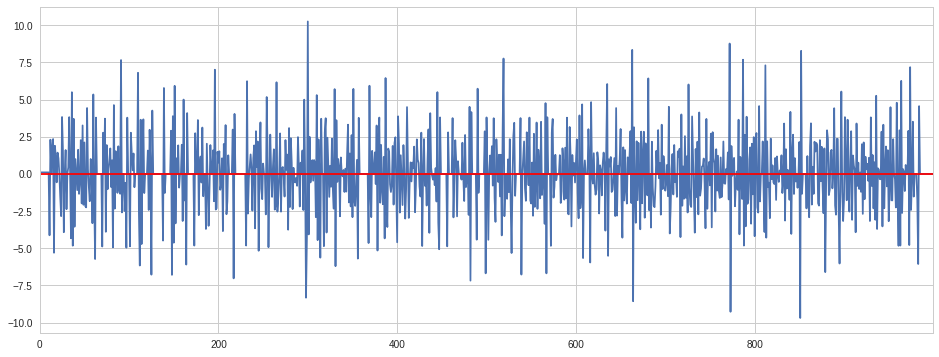

In [28]:
pd.Series(reward).plot(figsize=(16,6))
pd.Series(np.zeros_like(reward)).plot(figsize=(16,6), color='r')